Projeto Integrado - Pós-graduação Lato Sensu em Inteligência Artificial e Aprendizado de Máquina

Autor: Maison Henrique Pereira Fonseca Aawar

In [2]:
# Importar as Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler, SMOTEN, SVMSMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, fbeta_score, make_scorer

In [6]:
import warnings
warnings.filterwarnings('ignore')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [7]:
# configurações
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Parametros Gráfico
rc_params = {'axes.spines.top': False,
             'axes.spines.right': False,
             'legend.fontsize': 8,
             'legend.title_fontsize': 8,
             'legend.loc': 'upper right',
             'legend.fancybox': False,
             'axes.titleweight': 'bold',
             'axes.titlesize': 12,
             'axes.titlepad': 12}
sns.set_theme(style='ticks', rc=rc_params)
sns.set_color_codes('muted')

In [8]:
#Base de Dados
df = pd.read_csv('predictive_maintenance.csv', sep=',')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.10,308.60,1551,42.80,0,0,No Failure
1,2,L47181,L,298.20,308.70,1408,46.30,3,0,No Failure
2,3,L47182,L,298.10,308.50,1498,49.40,5,0,No Failure
3,4,L47183,L,298.20,308.60,1433,39.50,7,0,No Failure
4,5,L47184,L,298.20,308.70,1408,40.00,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.80,308.40,1604,29.50,14,0,No Failure
9996,9997,H39410,H,298.90,308.40,1632,31.80,17,0,No Failure
9997,9998,M24857,M,299.00,308.60,1645,33.40,22,0,No Failure
9998,9999,H39412,H,299.00,308.70,1408,48.50,25,0,No Failure


In [9]:
df = df.rename(columns={'Type': 'type', 'Air temperature [K]': 'air_temperature', 'Process temperature [K]': 'process_temperature', 'Rotational speed [rpm]': 'rotacional_speed',
               'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear', 'Target': 'target', 'Failure Type': 'failure_type'})

In [10]:
# Verificação do dataset
check_df = pd.DataFrame({
                    'type': df.dtypes,
                    'missing': df.isna().sum(),
                    'size': df.shape[0],
                    'unique': df.nunique()})
check_df['percentual_missing'] = round(check_df['missing'] / check_df['size'], 2)
check_df

,type,missing,size,unique,percentual_missing
UDI,int64,0,10000,10000,0.00
Product ID,object,0,10000,10000,0.00
type,object,0,10000,3,0.00
air_temperature,float64,0,10000,93,0.00
process_temperature,float64,0,10000,82,0.00
rotacional_speed,int64,0,10000,941,0.00
torque,float64,0,10000,577,0.00
tool_wear,int64,0,10000,246,0.00
target,int64,0,10000,2,0.00
failure_type,object,0,10000,6,0.00


In [11]:
# Alteração para float
df[['tool_wear', 'rotacional_speed']] = df[['tool_wear', 'rotacional_speed']].astype('float64')

In [12]:
# Verificação de anomalias na variável target
check_target = ['target','failure_type']

check_rnf = df.loc[df['failure_type'] == 'Random Failures'].index
df.loc[check_rnf,check_target]

,target,failure_type
1221,0,Random Failures
1302,0,Random Failures
1748,0,Random Failures
2072,0,Random Failures
2559,0,Random Failures
3065,0,Random Failures
3452,0,Random Failures
5471,0,Random Failures
5489,0,Random Failures
5495,0,Random Failures


In [13]:
drop_rnf = df.loc[check_rnf,check_target].shape[0]
print('Número de máquinas onde RNF = 1, mas falha da máquina = 0:',drop_rnf)

Número de máquinas onde RNF = 1, mas falha da máquina = 0: 18


É possivel verificar que algumas máquinas foram identificadas como No Failure (0), enquanto deveria ser Failure (1). Apenas 18 máquinas estão classficadas como Random Failures, que tem uma natureza aleatória, portanto não previsível, então decidi remover essas máquinas.

In [14]:
# Caso onde target = 1, mas nenhum tipo de falha é especificado
check_ambiguous = df.loc[(df['target']==1) & (df['failure_type']=='No Failure')].index
df.loc[check_ambiguous, check_target]

,target,failure_type
1437,1,No Failure
2749,1,No Failure
4044,1,No Failure
4684,1,No Failure
5536,1,No Failure
5941,1,No Failure
6478,1,No Failure
8506,1,No Failure
9015,1,No Failure


In [15]:
drop_ambiguous = df.loc[check_ambiguous].shape[0]
print('Número de máquinas onde target = 1, mas nenhum tipo de falha é especificado:', drop_ambiguous)

Número de máquinas onde target = 1, mas nenhum tipo de falha é especificado: 9


Neste caso, 9 máquinas estão classificadas como Failure(1), quando deveria estar classificadas como No Failure(0). Dessa forma, não é possivel afirmar que houve uma falha ou não, então decidi remover.

In [16]:
# Excluir as linhas onde há informações ambiguas
df.drop(index=check_rnf, inplace=True)
df.drop(index=check_ambiguous, inplace=True)

In [17]:
# Representação em porcentagem no dataset
print('Failure: {:.2f}%'.format((df[df.target == 1].shape[0] / df.shape[0]) * 100))
print('No Failure: {:.2f}%'.format((df[df.target == 0].shape[0] / df.shape[0]) * 100))

Failure: 3.31%
No Failure: 96.69%


In [18]:
# Excluindo colunas 
df = df.drop(['UDI', 'Product ID'], axis=1)
df

,type,air_temperature,process_temperature,rotacional_speed,torque,tool_wear,target,failure_type
0,M,298.10,308.60,1551.00,42.80,0.00,0,No Failure
1,L,298.20,308.70,1408.00,46.30,3.00,0,No Failure
2,L,298.10,308.50,1498.00,49.40,5.00,0,No Failure
3,L,298.20,308.60,1433.00,39.50,7.00,0,No Failure
4,L,298.20,308.70,1408.00,40.00,9.00,0,No Failure
...,...,...,...,...,...,...,...,...
9995,M,298.80,308.40,1604.00,29.50,14.00,0,No Failure
9996,H,298.90,308.40,1632.00,31.80,17.00,0,No Failure
9997,M,299.00,308.60,1645.00,33.40,22.00,0,No Failure
9998,H,299.00,308.70,1408.00,48.50,25.00,0,No Failure


EDA - Estatisca Descritiva

In [19]:
df[['air_temperature', 'process_temperature', 'rotacional_speed', 'torque', 'tool_wear']].describe()

,air_temperature,process_temperature,rotacional_speed,torque,tool_wear
count,9973.00,9973.00,9973.00,9973.00,9973.00
mean,300.00,310.00,1538.89,39.98,107.92
std,2.00,1.48,179.41,9.97,63.65
min,295.30,305.70,1168.00,3.80,0.00
25%,298.30,308.80,1423.00,33.20,53.00
50%,300.10,310.10,1503.00,40.10,108.00
75%,301.50,311.10,1612.00,46.70,162.00
max,304.50,313.80,2886.00,76.60,253.00


É possível identficar a presença de outliers em Rotacional Speed e Torque porque o máximo é muito diferente do terceiro quartil. De toda forma, para tornar essa consideração mais concreta, é preciso entender mais de perto essas informações nos gráficos de boxplots, e verificar a distribuição nos gráficos de histogramas.

In [20]:
# Skewness Analysis
df_skew =  df.loc[:,['air_temperature', 'process_temperature', 'rotacional_speed', 'torque', 'tool_wear']]
skew = df_skew.skew()
skew

air_temperature        0.12
process_temperature    0.02
rotacional_speed       1.99
torque                -0.01
tool_wear              0.03
dtype: float64

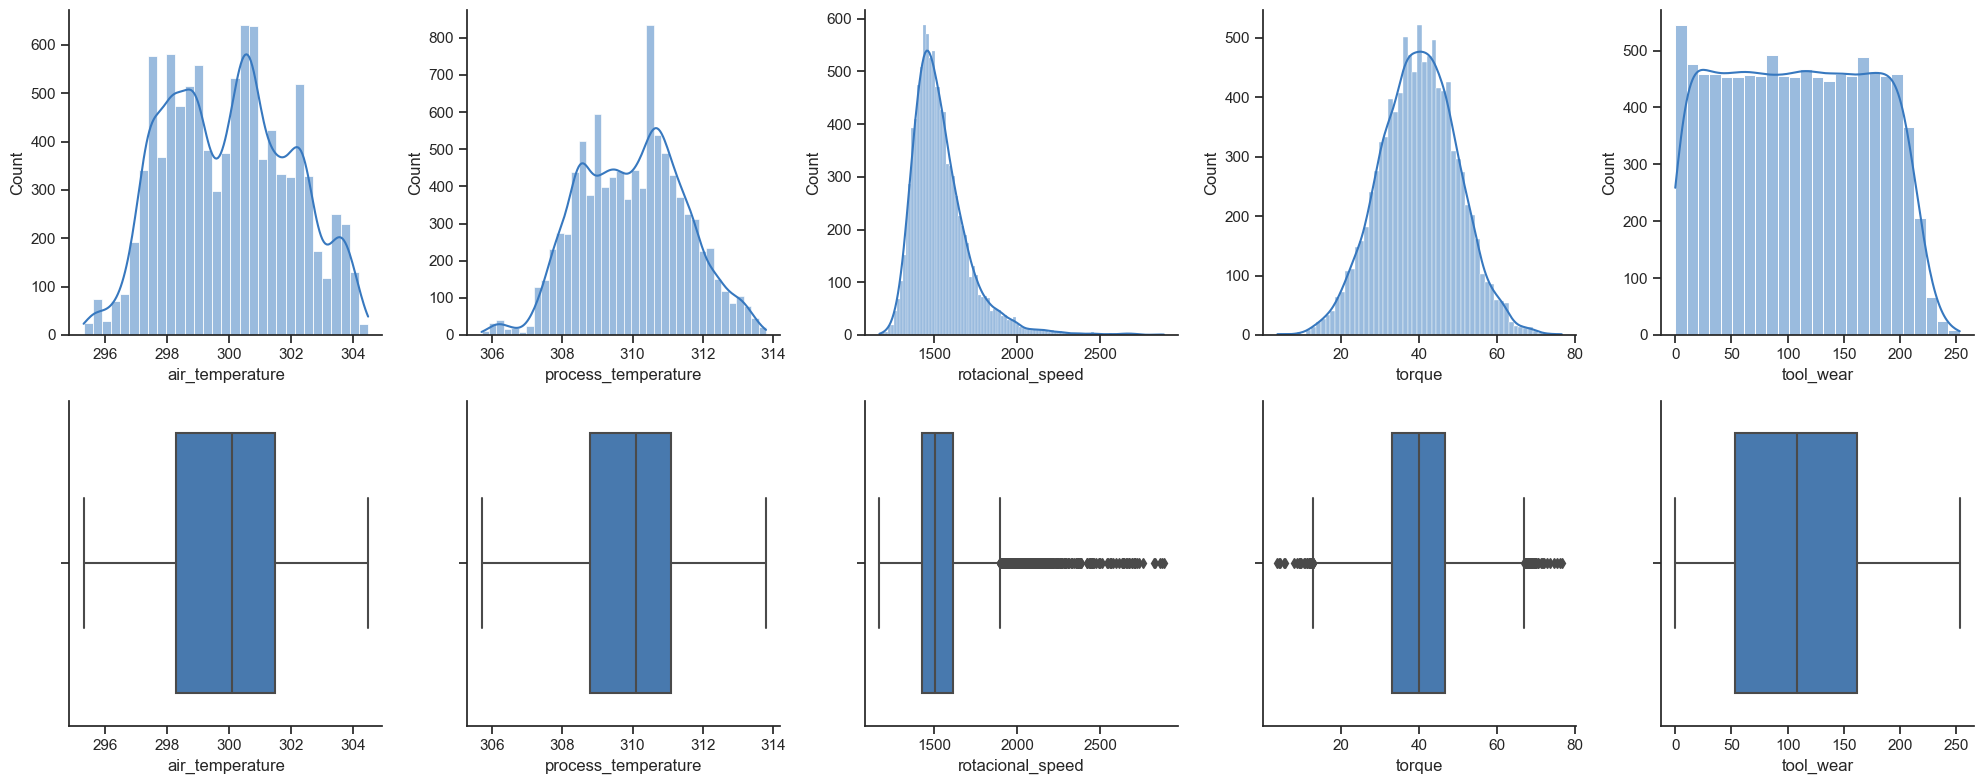

In [21]:
# Gráfico de Histograma e Boxplot
features = [col for col in df.columns if df[col].dtype=='float64' or col =='type']
num_features = [feature for feature in features if df[feature].dtype=='float64']

fig, ax= plt.subplots(nrows=2, ncols=5, figsize=(20,8), constrained_layout=True)
for j, feature in enumerate(num_features):
    sns.histplot(ax=ax[0, j-5*(j//5)], data=df, x=feature, kde=True, color=sns.xkcd_rgb['windows blue'])
    sns.boxplot(ax=ax[1, j-5*(j//5)], data=df, x=feature, color=sns.xkcd_rgb['windows blue'])

plt.tight_layout()
plt.show()

Os boxplots destacam possíveis outliers nos recursos mencionados acima, no entanto, no caso de Torque e Velocidade de Rotação. Como resultado, mantemos os outliers por enquanto e nos reservamos o direito de decidir se devemos ou não agir sobre eles depois de considerar outros aspectos.

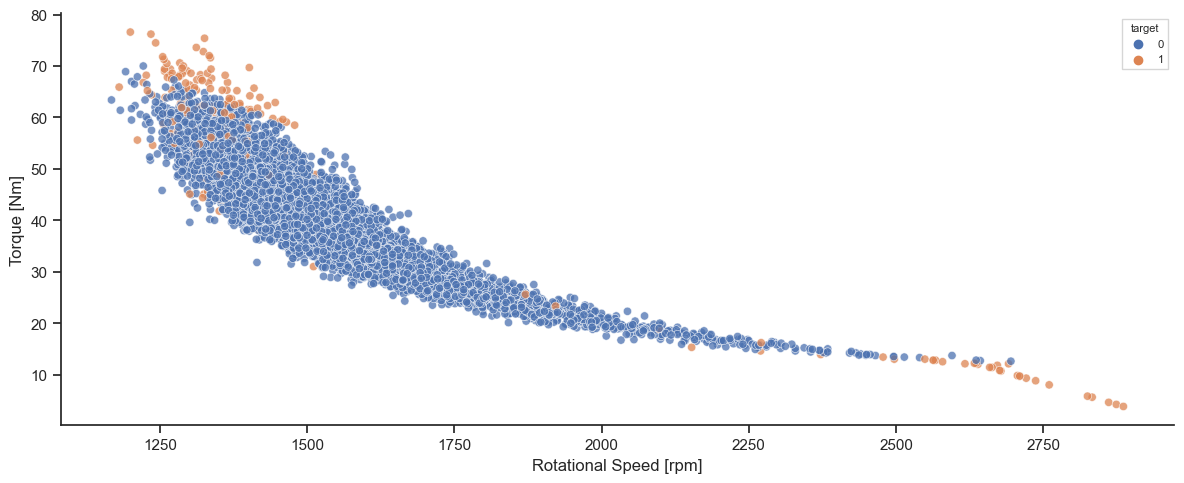

In [22]:
# Relação entre variáveis
plt.figure(figsize=(12,5))
sns.scatterplot(x='rotacional_speed', y='torque', hue='target', alpha=0.75, data=df)
plt.xlabel('Rotational Speed [rpm]')
plt.ylabel('Torque [Nm]')
#plt.title('Rotational Speed [rpm] x Torque [Nm]', fontsize=12, loc='left', pad=10)
plt.tight_layout()
plt.show()

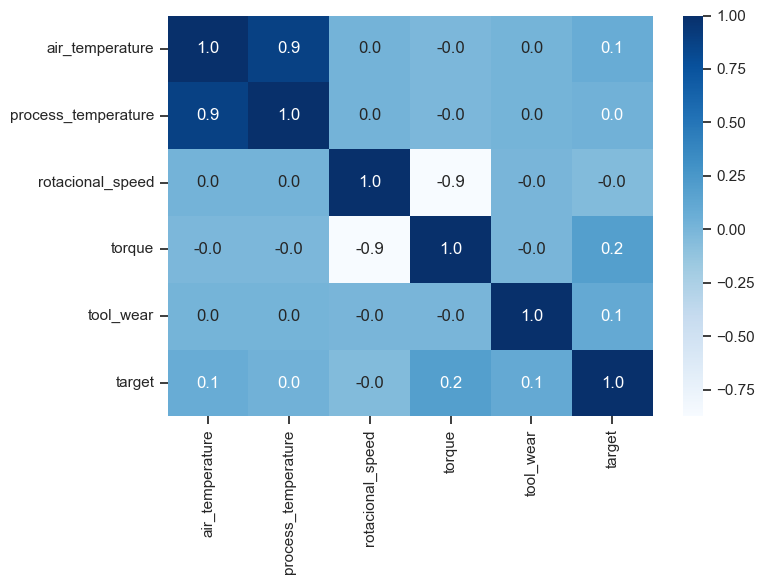

In [23]:
# Gráfico de Correlação
plt.figure(figsize = (8, 6))
sns.heatmap(df.corr(), cmap='Blues', annot=True, fmt="1.1f")
#plt.title('Correlação', fontsize=12, loc='left', pad=12)
plt.tight_layout()
plt.show()

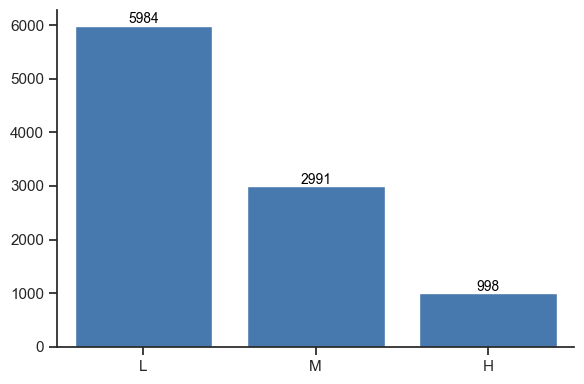

In [24]:
# Tipo de Produto
ax2 = plt.subplots(figsize=(6, 4))
ax2 = sns.countplot(x ='type', data = df, order = ['L', 'M', 'H'], color = sns.xkcd_rgb['windows blue'])
#plt.title('Tipo de Produto', fontsize=12, loc='left', pad=12)

for i in ax2.patches:
    h = i.get_height()
    ax2.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

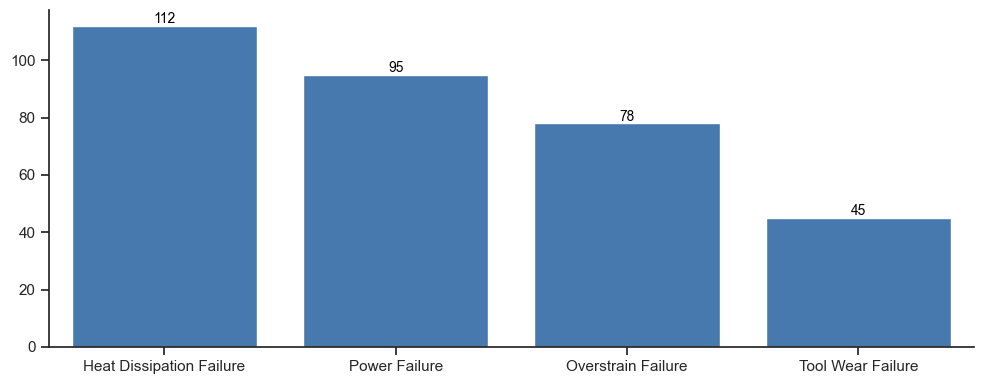

In [25]:
# Número de Tipos de Falhas
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.countplot(x='failure_type', color = sns.xkcd_rgb['windows blue'], data= df, 
                                order = ['Heat Dissipation Failure', 'Power Failure', 'Overstrain Failure', 'Tool Wear Failure'])
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')

#plt.title('Número de Tipos de Falhas', fontsize=12, loc='left', pad=10)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

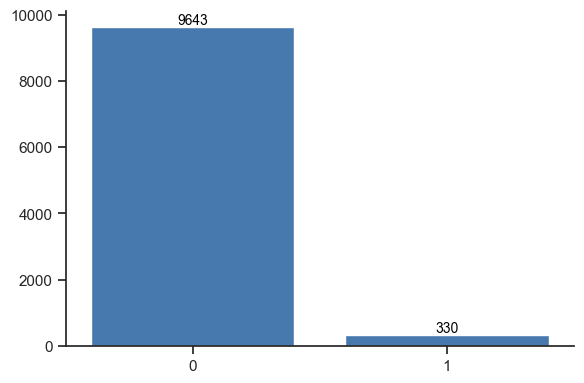

In [26]:
# Gráfico varável target
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(x=df.target, color = sns.xkcd_rgb['windows blue'])
#plt.title('Quantidade de Falhas', fontsize=12, loc='left', pad=12)
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [27]:
# Representação em porcentagem no dataset
print('No Failure: {:.2f}%'.format((df[df.target == 0].shape[0] / df.shape[0]) * 100))
print('Failure: {:.2f}%'.format((df[df.target == 1].shape[0] / df.shape[0]) * 100))

No Failure: 96.69%
Failure: 3.31%


Preparação dos Dados para os Modelos de Aprendizado de Máquina

Features scaling and Encoding

In [28]:
df1 = df.copy()
type_dict = {'L': 0, 'M': 1, 'H': 2}
cause_dict = {'No Failure': 0,
              'Power Failure': 1,
              'Overstrain Failure': 2,
              'Heat Dissipation Failure': 3,
              'Tool Wear Failure': 4}

# Encoding
df1['type'].replace(to_replace=type_dict, inplace=True)
df1['failure_type'].replace(to_replace=cause_dict, inplace=True)
df1

,type,air_temperature,process_temperature,rotacional_speed,torque,tool_wear,target,failure_type
0,1,298.10,308.60,1551.00,42.80,0.00,0,0
1,0,298.20,308.70,1408.00,46.30,3.00,0,0
2,0,298.10,308.50,1498.00,49.40,5.00,0,0
3,0,298.20,308.60,1433.00,39.50,7.00,0,0
4,0,298.20,308.70,1408.00,40.00,9.00,0,0
...,...,...,...,...,...,...,...,...
9995,1,298.80,308.40,1604.00,29.50,14.00,0,0
9996,2,298.90,308.40,1632.00,31.80,17.00,0,0
9997,1,299.00,308.60,1645.00,33.40,22.00,0,0
9998,2,299.00,308.70,1408.00,48.50,25.00,0,0


Classificação Binária - Variável Target

In [29]:
# Definindo os classificadores
classifiers = {
    'SVC': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(objective='binary:hinge', random_state=42),
    'LightGBM': LGBMClassifier(objective='binary', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [30]:
# Separando os dados em treinamento e teste
X = df1.drop(['target', 'failure_type'], axis=1)
y = df1['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

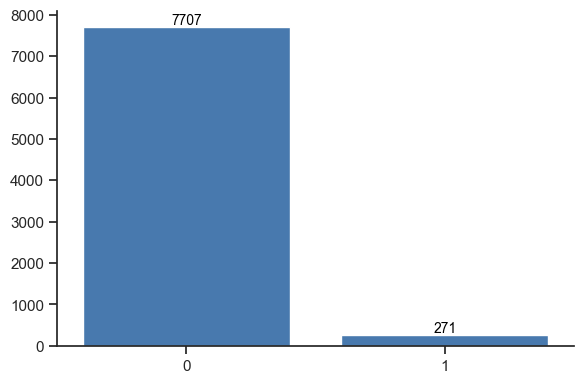

In [31]:
# Verificando os dados antes do balanceamento
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(x=y_train, color = sns.xkcd_rgb['windows blue'])
#plt.title('Distribuição das classes (Antes do balanceamento)', fontsize=12, loc='left', pad=12)
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

Balanceamento dos dados

In [32]:
# Função para balanceamento dos dados
def balance_data_binary(X_train, y_train, method='SMOTE'):
    if method == 'SMOTE':
        smote = SMOTE(random_state=42)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    elif method == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)
    elif method == 'BorderlineSMOTE':
        blsmote = BorderlineSMOTE(random_state=42)
        X_train_balanced, y_train_balanced = blsmote.fit_resample(X_train, y_train)
    elif method == 'SVMSMOTE':
        svmsmote = SVMSMOTE(random_state=42)
        X_train_balanced, y_train_balanced = svmsmote.fit_resample(X_train, y_train)
    elif method == 'SMOTEN':
        smoten = SMOTEN(random_state=42)
        X_train_balanced, y_train_balanced = smoten.fit_resample(X_train, y_train)
    elif method == 'RandomOverSampler':
        rdsampler = RandomOverSampler(random_state=42)
        X_train_balanced, y_train_balanced = rdsampler.fit_resample(X_train, y_train)
    else:
        X_train_balanced, y_train_balanced = X_train, y_train
        
    return X_train_balanced, y_train_balanced

In [33]:
# Balanceando os dados de treinamento
X_train_balanced, y_train_balanced = balance_data_binary(X_train, y_train, method='SMOTEN')

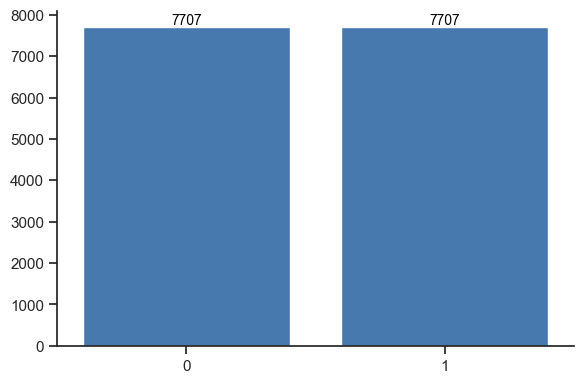

In [34]:
# Verificando o balanceamento dos dados após o balanceamento
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(x=y_train_balanced, color = sns.xkcd_rgb['windows blue'])
#plt.title('Distribuição das classes (Após o balanceamento)', fontsize=12, loc='left', pad=12)
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

Treinando os modelos

In [35]:
# Função para treinar os modelos
def train_models_binary(classifiers, X_train, y_train):
    trained_models_binary = {}
    
    for clf_name, clf in classifiers.items():
        pipeline = make_pipeline(RobustScaler(), clf)
        pipeline.fit(X_train, y_train)
        trained_models_binary[clf_name] = pipeline
    
    return trained_models_binary

In [36]:
# Treinando os modelos finais com todos os dados de treinamento usando todos os classificadores
trained_models_binary = train_models_binary(classifiers, X_train_balanced, y_train_balanced)

In [37]:
# Criando uma tabela com os modelos treinados e os resultados no conjunto de teste
results_df_binary = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

for clf_name, model in trained_models_binary.items():
    y_pred = model.predict(X_test)
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results_df_binary = results_df_binary.append({
        'Model': clf_name,                  
        'Accuracy': clf_report['accuracy'],
        'Precision': clf_report['macro avg']['precision'],
        'Recall': clf_report['macro avg']['recall'],
        'F1-score': clf_report['macro avg']['f1-score'],
        'ROC-AUC': roc_auc
    }, ignore_index=True)
    
print("\nResults on Test Set:")
print(results_df_binary)


Results on Test Set:
                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC
0                  SVC      0.94       0.62    0.73      0.66     0.73
1  Logistic Regression      0.88       0.55    0.68      0.56     0.68
2        Random Forest      0.98       0.87    0.75      0.80     0.75
3              XGBoost      0.98       0.79    0.82      0.80     0.82
4             LightGBM      0.98       0.86    0.88      0.87     0.88
5    Gradient Boosting      0.96       0.67    0.77      0.70     0.77


--- SVC ---
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1936
           1       0.26      0.51      0.34        59

    accuracy                           0.94      1995
   macro avg       0.62      0.73      0.66      1995
weighted avg       0.96      0.94      0.95      1995



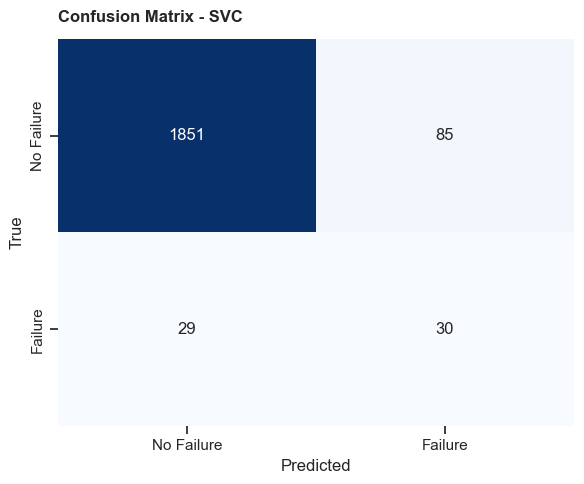


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      1936
           1       0.12      0.46      0.18        59

    accuracy                           0.88      1995
   macro avg       0.55      0.68      0.56      1995
weighted avg       0.96      0.88      0.91      1995



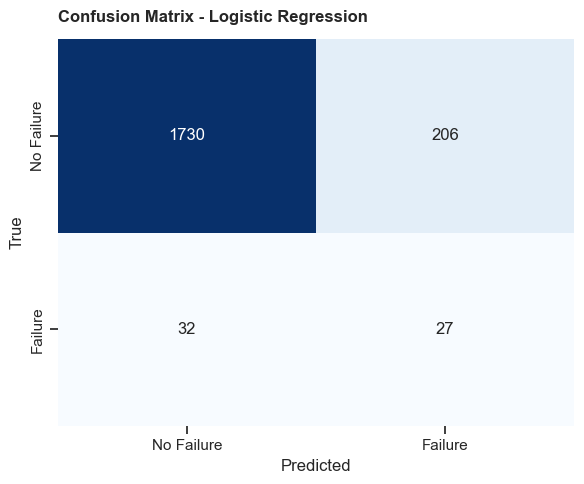


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1936
           1       0.75      0.51      0.61        59

    accuracy                           0.98      1995
   macro avg       0.87      0.75      0.80      1995
weighted avg       0.98      0.98      0.98      1995



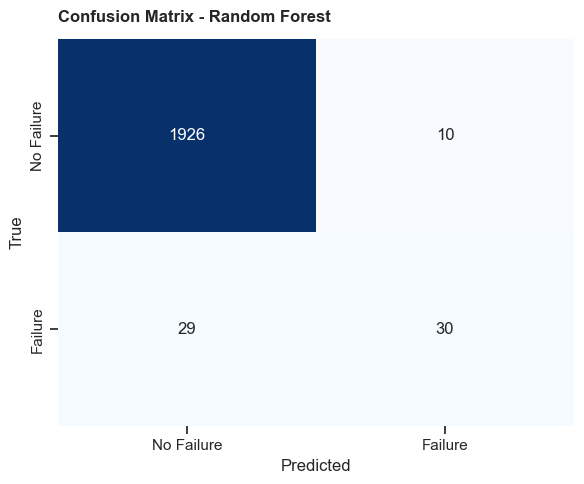


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1936
           1       0.59      0.64      0.62        59

    accuracy                           0.98      1995
   macro avg       0.79      0.82      0.80      1995
weighted avg       0.98      0.98      0.98      1995



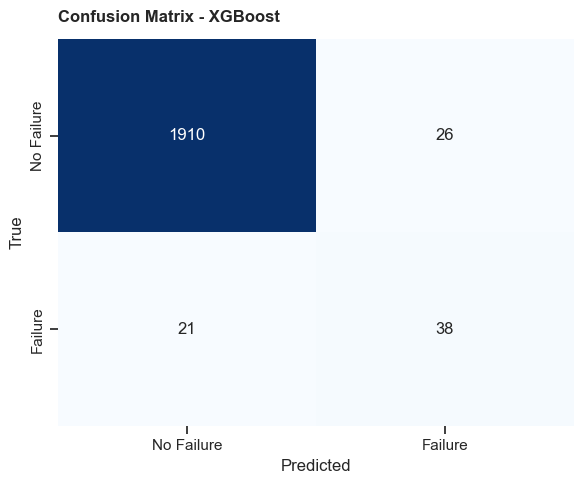


--- LightGBM ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1936
           1       0.73      0.76      0.74        59

    accuracy                           0.98      1995
   macro avg       0.86      0.88      0.87      1995
weighted avg       0.98      0.98      0.98      1995



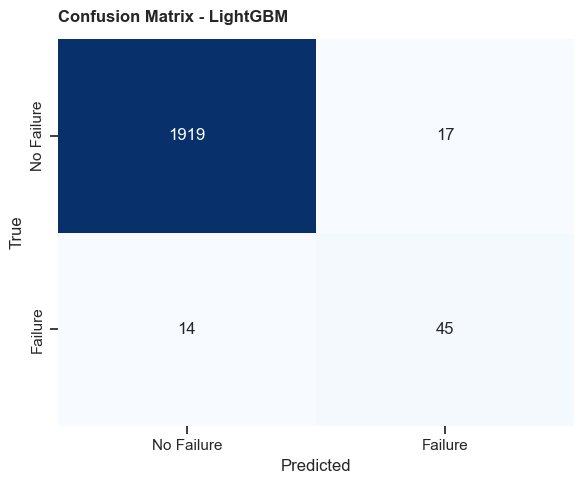


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1936
           1       0.35      0.58      0.43        59

    accuracy                           0.96      1995
   macro avg       0.67      0.77      0.70      1995
weighted avg       0.97      0.96      0.96      1995



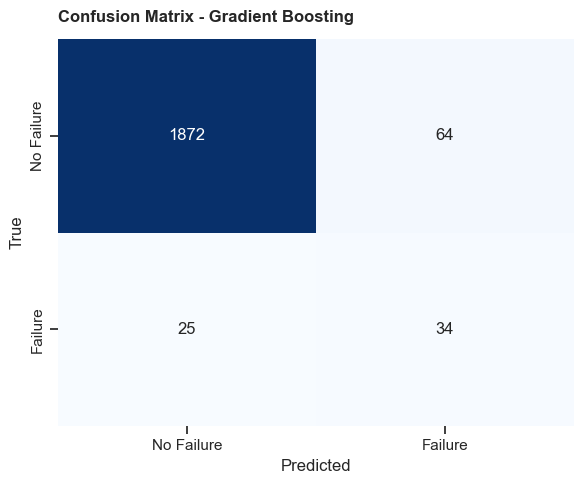

In [38]:
# Avaliando o desempenho dos modelos finais no conjunto de teste
for clf_name, model in trained_models_binary.items():
    print('---', clf_name, '---')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Calculando e exibindo a matriz de confusão como um gráfico
    cm = confusion_matrix(y_test, y_pred)
    f, ax = plt.subplots(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {clf_name}', fontsize=12, loc='left', pad=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(['No Failure', 'Failure'])  
    ax.yaxis.set_ticklabels(['No Failure', 'Failure'])
    plt.tight_layout()
    plt.show()
    print()

Hiperparametros - Classificação Binária

In [35]:
# Definindo os hiperparâmetros para ajuste - Classificação Binária
param_grid_binary = {
    'SVC': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
    'Logistic Regression': {'logisticregression__C': [0.1, 1, 10], 'logisticregression__solver': ['liblinear', 'saga']},
    'Random Forest': {'randomforestclassifier__n_estimators': [25, 50, 500, 1000], 'randomforestclassifier__max_depth': [5, 30, 100, 1000]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.1, 0.10, 0.15, 0.20], 'xgbclassifier__n_estimators': [50, 100, 500, 1000]},
    'LightGBM': {'lgbmclassifier__learning_rate': [0.1, 0.01, 0.10, 0.20], 'lgbmclassifier__n_estimators': [50, 100, 500, 1000]},
    'Gradient Boosting': {'gradientboostingclassifier__learning_rate': [0.1, 0.03, 0.10, 0.20], 'gradientboostingclassifier__n_estimators': [50, 100, 200, 1000]}
}

In [36]:
# Função para treinar os hiperparâmetros
def train_hyperparameters_binary(classifiers, X_train, y_train, param_grid_binary):
    trained_hy_binary = {}
    best_params_hy_binary = {}
    
    for clf_name, clf in classifiers.items():
        pipeline = make_pipeline(StandardScaler(), clf)

        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f2_score = make_scorer(fbeta_score, pos_label=1, beta=0.5)
        grid_search = GridSearchCV(pipeline, param_grid=param_grid_binary[clf_name], scoring=f2_score, cv=kfold, n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)
        
        best_estimator = grid_search.best_estimator_
        best_params_hy_binary[clf_name] = grid_search.best_params_
        
        trained_hy_binary[clf_name] = best_estimator
    
    return trained_hy_binary, best_params_hy_binary

In [37]:
# Treinando os modelos com os melhores hiperparâmetros usando GridSearchCV
trained_hy_binary, best_params_hy_binary = train_hyperparameters_binary(classifiers, X_train_balanced, y_train_balanced, param_grid_binary)

In [38]:
# Exibindo os melhores hiperparâmetros encontrados
print("\nBest Hyperparameters:")
for clf_name, params in best_params_hy_binary.items():
    print(f"{clf_name}: {params}")


Best Hyperparameters:
SVC: {'svc__C': 10, 'svc__kernel': 'rbf'}
Logistic Regression: {'logisticregression__C': 10, 'logisticregression__solver': 'liblinear'}
Random Forest: {'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 1000}
XGBoost: {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__n_estimators': 100}
LightGBM: {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__n_estimators': 1000}
Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__n_estimators': 1000}


In [39]:
# Criando uma tabela com os modelos treinados e os resultados no conjunto de teste
results_hy_binary = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])

for clf_name, model in trained_hy_binary.items():
    y_pred = model.predict(X_test)
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    results_hy_binary = results_hy_binary.append({
        'Model': clf_name,
        'Accuracy': clf_report['accuracy'],
        'Precision': clf_report['macro avg']['precision'],
        'Recall': clf_report['macro avg']['recall'],
        'F1-score': clf_report['macro avg']['f1-score'],
        'ROC-AUC': roc_auc
    }, ignore_index=True)

print("\nResults on Test Set:")
print(results_hy_binary)


Results on Test Set:
                 Model  Accuracy  Precision  Recall  F1-score  ROC-AUC
0                  SVC      0.95       0.67    0.80      0.71     0.80
1  Logistic Regression      0.88       0.55    0.68      0.56     0.68
2        Random Forest      0.98       0.92    0.75      0.81     0.75
3              XGBoost      0.98       0.86    0.85      0.86     0.85
4             LightGBM      0.99       0.93    0.89      0.91     0.89
5    Gradient Boosting      0.98       0.85    0.88      0.86     0.88


--- SVC ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1936
           1       0.35      0.63      0.45        59

    accuracy                           0.95      1995
   macro avg       0.67      0.80      0.71      1995
weighted avg       0.97      0.95      0.96      1995




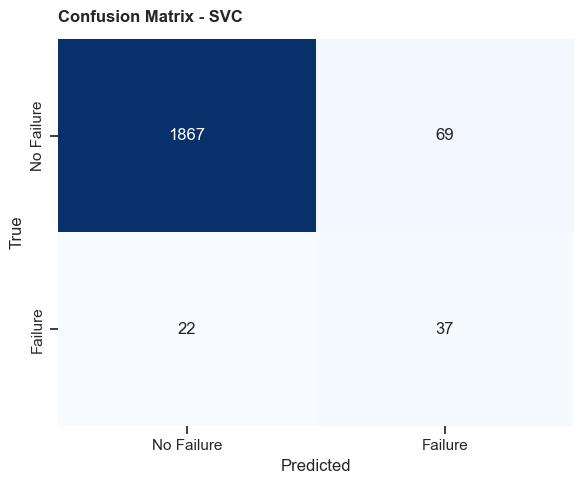


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.89      0.94      1936
           1       0.12      0.46      0.18        59

    accuracy                           0.88      1995
   macro avg       0.55      0.68      0.56      1995
weighted avg       0.96      0.88      0.91      1995




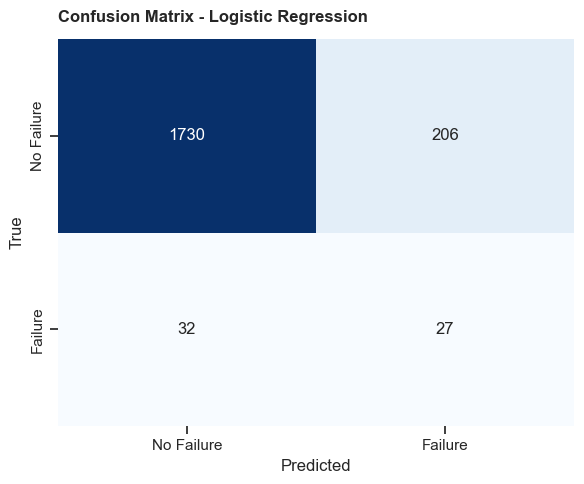


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1936
           1       0.86      0.51      0.64        59

    accuracy                           0.98      1995
   macro avg       0.92      0.75      0.81      1995
weighted avg       0.98      0.98      0.98      1995




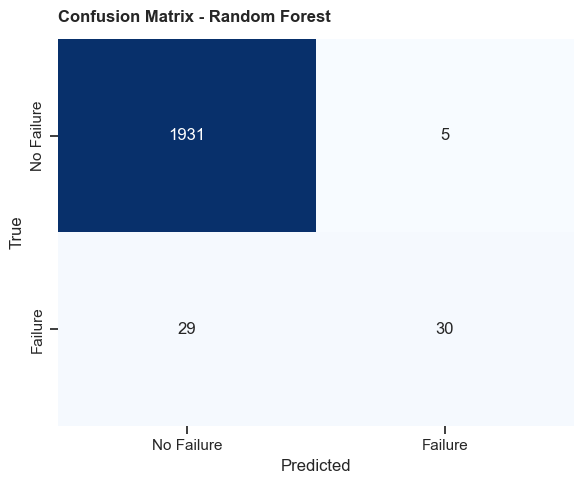


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1936
           1       0.74      0.71      0.72        59

    accuracy                           0.98      1995
   macro avg       0.86      0.85      0.86      1995
weighted avg       0.98      0.98      0.98      1995




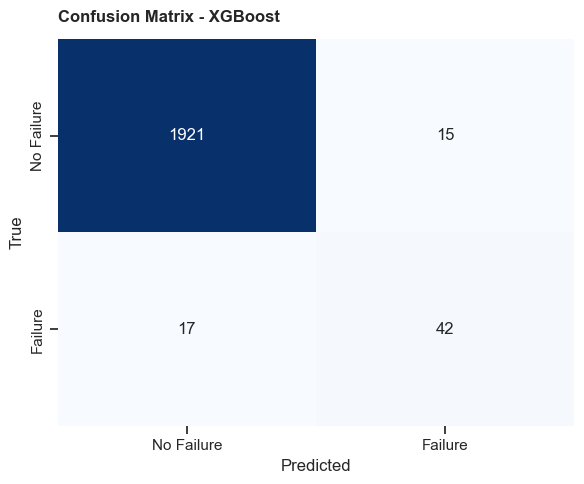


--- LightGBM ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1936
           1       0.87      0.78      0.82        59

    accuracy                           0.99      1995
   macro avg       0.93      0.89      0.91      1995
weighted avg       0.99      0.99      0.99      1995




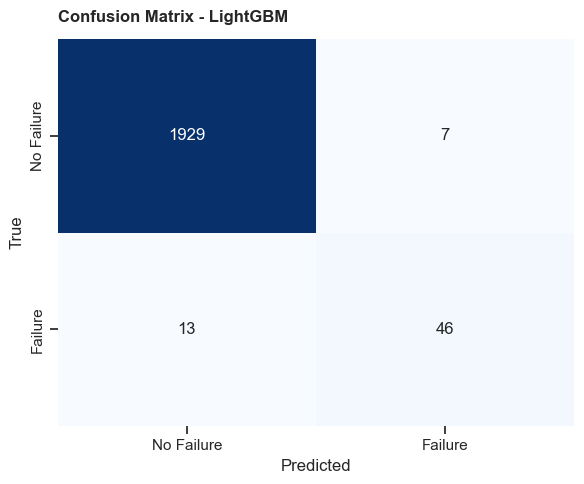


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1936
           1       0.70      0.76      0.73        59

    accuracy                           0.98      1995
   macro avg       0.85      0.88      0.86      1995
weighted avg       0.98      0.98      0.98      1995




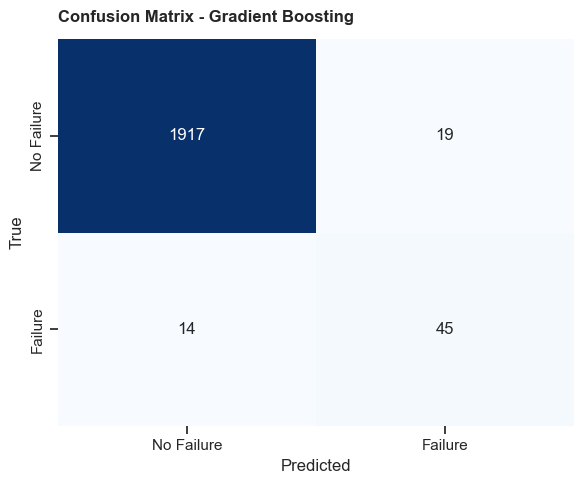

In [40]:
# Avaliando o desempenho dos modelos finais no conjunto de teste com hiperparâmetros
for clf_name, model in trained_hy_binary.items():
    print('---', clf_name, '---')
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print()

    # Calculando e exibindo a matriz de confusão como um gráfico
    cm = confusion_matrix(y_test, y_pred)
    f, ax = plt.subplots(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {clf_name}', fontsize=12, loc='left', pad=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(['No Failure', 'Failure'])  
    ax.yaxis.set_ticklabels(['No Failure', 'Failure'])
    plt.tight_layout()
    plt.show()
    print()

Classificação Multiclasse - Variável Failure Type

In [83]:
# Definindo os classificadores com hiperparâmetros
classifiers_multi = {
    'SVC': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(objective='multi:softprob', random_state=42),
    'LightGBM': LGBMClassifier(objective='multiclass', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

In [84]:
# Separando os dados em treinamento e teste
X_multi = df1.drop(['target', 'failure_type'], axis=1)
y_multi = df1['failure_type']
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y_multi, test_size=0.30, random_state=42)

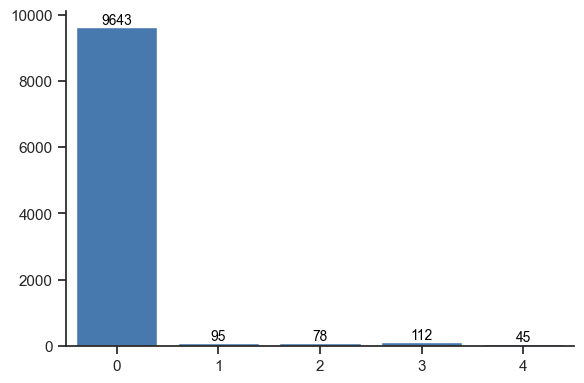

In [85]:
# Verificando os dados antes do balanceamento
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(x=y_multi, color = sns.xkcd_rgb['windows blue'])
#plt.title('Distribuição das classes (Antes do balanceamento)', fontsize=12, loc='left', pad=12)
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

Balanceamento dos dados

In [86]:
# Função para balanceamento dos dados
def balance_data(X_train_m, y_train_m, method='SMOTE'):
    if method == 'SMOTE':
        smote = SMOTE(random_state=42)
        X_train_m_balanced, y_train_m_balanced = smote.fit_resample(X_train_m, y_train_m)
    elif method == 'ADASYN':
        adasyn = ADASYN(random_state=42)
        X_train_m_balanced, y_train_m_balanced = adasyn.fit_resample(X_train_m, y_train_m)
    elif method == 'BorderlineSMOTE':
        blsmote = BorderlineSMOTE(random_state=42)
        X_train_m_balanced, y_train_m_balanced = blsmote.fit_resample(X_train_m, y_train_m)
    elif method == 'RandomOverSampler':
        rus = RandomOverSampler(random_state=42)
        X_train_m_balanced, y_train_m_balanced = rus.fit_resample(X_train_m, y_train_m)
    else:
        X_train_m_balanced, y_train_m_balanced = X_train_m, y_train_m
    
    return X_train_m_balanced, y_train_m_balanced

In [87]:
# Balanceando os dados de treinamento
X_train_m_balanced, y_train_m_balanced = balance_data(X_train_m, y_train_m, method='SMOTE')

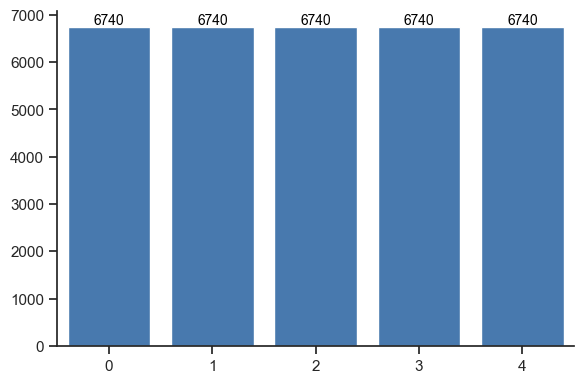

In [88]:
# Verificando o balanceamento dos dados após o balanceamento
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.countplot(x=y_train_m_balanced, color = sns.xkcd_rgb['windows blue'])
#plt.title('Distribuição das classes (Após o balanceamento)', fontsize=12, loc='left', pad=12)
for i in ax.patches:
    h = i.get_height()
    ax.annotate('{:.0f}'.format(h),
                  (i.get_x() + i.get_width()/2, h),
                  ha='center',
                  va='baseline',
                  fontsize=10,
                  color='black',
                  xytext=(0, 2),
                  textcoords='offset points')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

Treinando os modelos

In [89]:
# Função para treinar os modelos
def train_models(classifiers_multi, X_train_m, y_train_m):
    trained_models = {}
    
    for clf_name, clf in classifiers_multi.items():
        pipeline = make_pipeline(RobustScaler(), clf)
        pipeline.fit(X_train_m, y_train_m)
        trained_models[clf_name] = pipeline
    
    return trained_models

In [90]:
# Treinando os modelos finais com todos os dados de treinamento usando todos os classificadores
trained_models = train_models(classifiers_multi, X_train_m_balanced, y_train_m_balanced)

In [91]:
# Criando uma tabela com os modelos treinados e os resultados no conjunto de teste
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

for clf_name, model in trained_models.items():
    y_pred_m = model.predict(X_test_m)
    clf_report = classification_report(y_test_m, y_pred_m, output_dict=True)
    
    results_df = results_df.append({
        'Model': clf_name,                  
        'Accuracy': clf_report['accuracy'],
        'Precision': clf_report['macro avg']['precision'],
        'Recall': clf_report['macro avg']['recall'],
        'F1-score': clf_report['macro avg']['f1-score']
    }, ignore_index=True)

print("\nResults on Test Set:")
print(results_df)


Results on Test Set:
                 Model  Accuracy  Precision  Recall  F1-score
0                  SVC      0.91       0.45    0.83      0.54
1  Logistic Regression      0.88       0.39    0.85      0.48
2        Random Forest      0.97       0.60    0.77      0.65
3              XGBoost      0.98       0.66    0.79      0.71
4             LightGBM      0.98       0.66    0.80      0.71
5    Gradient Boosting      0.95       0.58    0.87      0.66


--- SVC ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2903
           1       0.57      0.91      0.70        32
           2       0.29      0.85      0.43        13
           3       0.36      0.91      0.52        32
           4       0.05      0.58      0.08        12

    accuracy                           0.91      2992
   macro avg       0.45      0.83      0.54      2992
weighted avg       0.98      0.91      0.94      2992




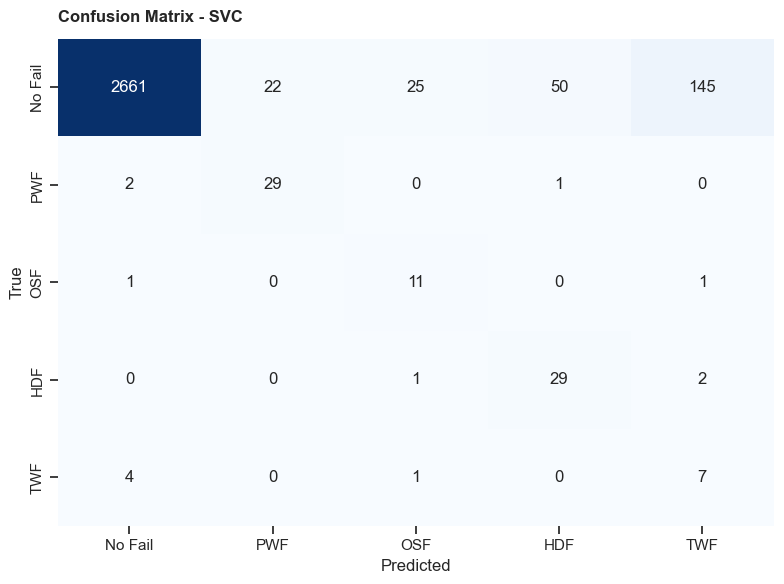


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2903
           1       0.45      1.00      0.62        32
           2       0.19      0.92      0.32        13
           3       0.29      0.97      0.45        32
           4       0.03      0.50      0.06        12

    accuracy                           0.88      2992
   macro avg       0.39      0.85      0.48      2992
weighted avg       0.98      0.88      0.92      2992




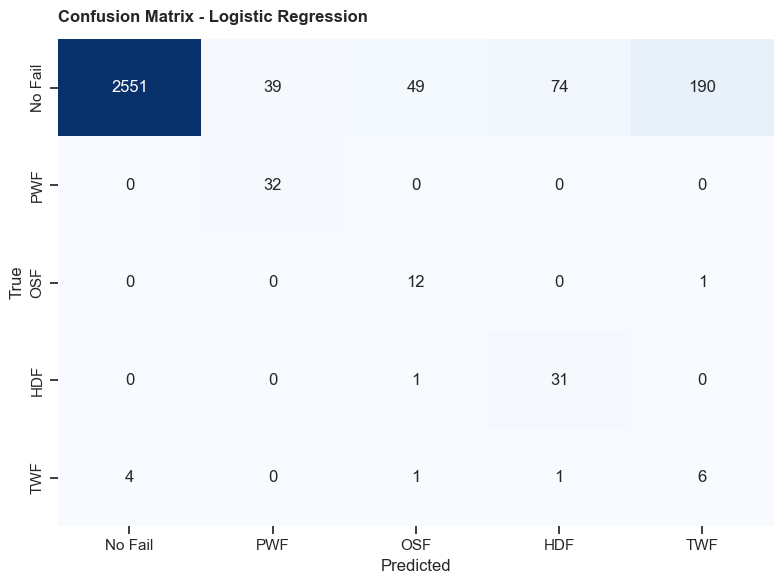


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2903
           1       0.74      0.81      0.78        32
           2       0.44      0.85      0.58        13
           3       0.74      0.81      0.78        32
           4       0.10      0.42      0.16        12

    accuracy                           0.97      2992
   macro avg       0.60      0.77      0.65      2992
weighted avg       0.98      0.97      0.97      2992




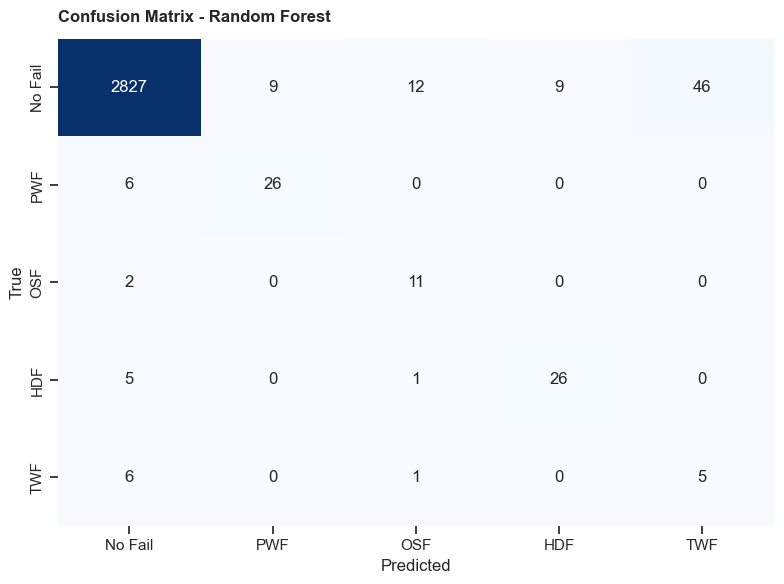


--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2903
           1       0.76      0.88      0.81        32
           2       0.65      0.85      0.73        13
           3       0.84      1.00      0.91        32
           4       0.08      0.25      0.12        12

    accuracy                           0.98      2992
   macro avg       0.66      0.79      0.71      2992
weighted avg       0.99      0.98      0.98      2992




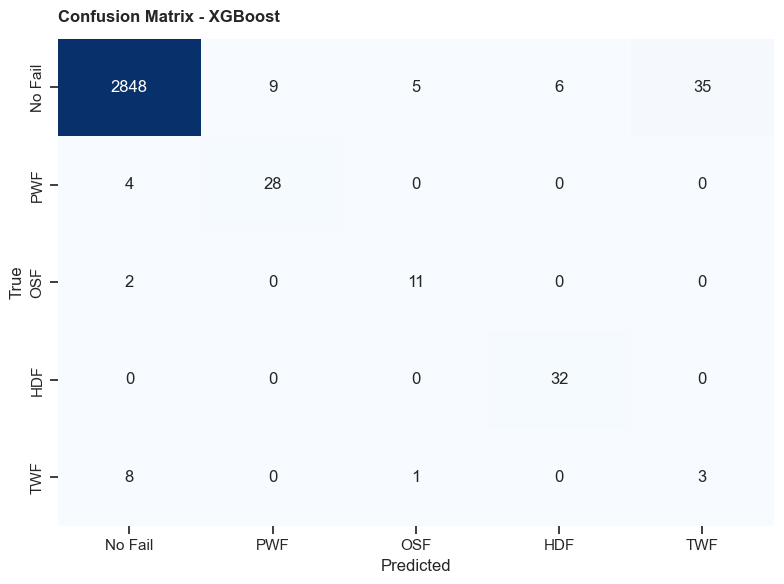


--- LightGBM ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2903
           1       0.74      0.78      0.76        32
           2       0.63      0.92      0.75        13
           3       0.86      0.97      0.91        32
           4       0.10      0.33      0.15        12

    accuracy                           0.98      2992
   macro avg       0.66      0.80      0.71      2992
weighted avg       0.99      0.98      0.98      2992




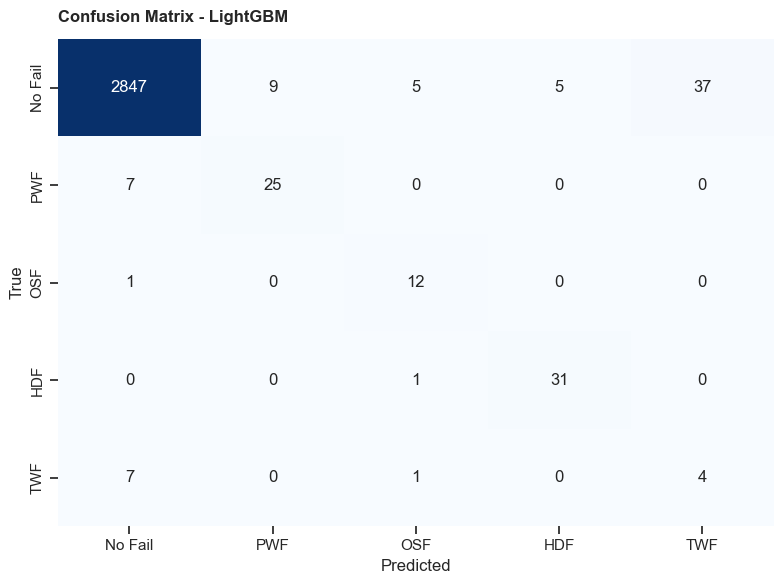


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2903
           1       0.67      0.94      0.78        32
           2       0.39      0.92      0.55        13
           3       0.76      0.97      0.85        32
           4       0.07      0.58      0.13        12

    accuracy                           0.95      2992
   macro avg       0.58      0.87      0.66      2992
weighted avg       0.99      0.95      0.97      2992




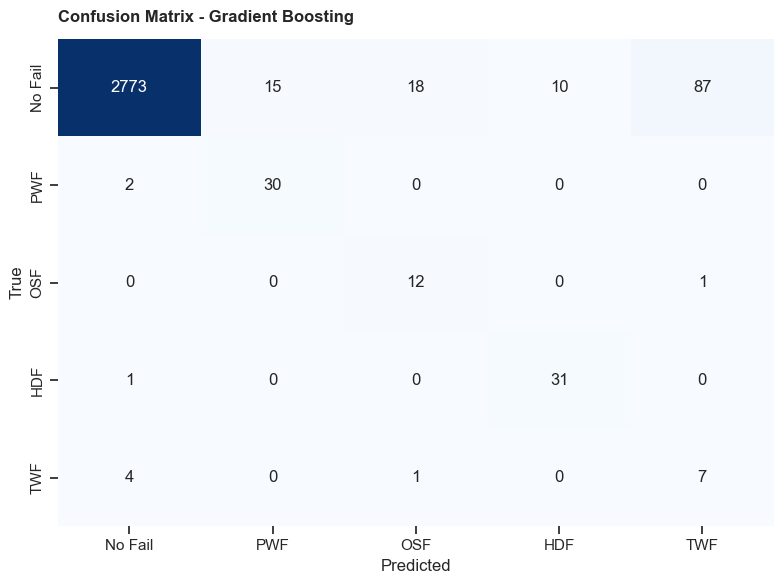

In [92]:
# Avaliando o desempenho dos modelos finais no conjunto de teste
for clf_name, model in trained_models.items():
    print('---', clf_name, '---')
    y_pred_m = model.predict(X_test_m)
    print(classification_report(y_test_m, y_pred_m))
    print()

    # Calculando e exibindo a matriz de confusão como um gráfico
    cm = confusion_matrix(y_test_m, y_pred_m)
    f, ax = plt.subplots(figsize=(8, 6))
    ax= sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {clf_name}', fontsize=12, loc='left', pad=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(['No Fail', 'PWF', 'OSF', 'HDF', 'TWF'])
    ax.yaxis.set_ticklabels(['No Fail', 'PWF', 'OSF', 'HDF', 'TWF'])
    plt.tight_layout()
    plt.show()
    print()

Hiperparâmetros - Classificação multiclasse

In [93]:
# Definindo os hiperparâmetros para ajuste
param_grid = {
    'SVC': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
    'Logistic Regression': {'logisticregression__C': [0.1, 1, 10], 'logisticregression__solver': ['liblinear', 'saga']},
    'Random Forest': {'randomforestclassifier__n_estimators': [25, 50, 500, 1000], 'randomforestclassifier__max_depth': [5, 30, 100, 1000]},
    'XGBoost': {'xgbclassifier__learning_rate': [0.10, 0.20, 0.30, 0.50], 'xgbclassifier__n_estimators': [50, 100, 500, 1000]},
    'LightGBM': {'lgbmclassifier__learning_rate': [0.10, 0.20, 0.30, 0.50], 'lgbmclassifier__n_estimators': [50, 100, 500, 1000]},
    'Gradient Boosting': {'gradientboostingclassifier__learning_rate': [0.1, 0.03, 0.10, 0.20], 'gradientboostingclassifier__n_estimators': [50, 100, 200, 1000]}
}

In [94]:
# Função para treinar os hiperparâmetros
def train_hyperparameters(classifiers_multi, X_train_m, y_train_m, param_grid):
    trained_hy_models = {}
    best_params_hy = {}
    
    for clf_name, clf in classifiers_multi.items():
        pipeline = make_pipeline(RobustScaler(), clf)
        
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f2_score_multi = make_scorer(fbeta_score, pos_label=None, beta=2, average='weighted')
        grid_search_multi = GridSearchCV(pipeline, param_grid=param_grid[clf_name], scoring=f2_score_multi, cv=kfold, n_jobs=-1, return_train_score=True)
        grid_search_multi.fit(X_train_m, y_train_m)

        best_estimator = grid_search_multi.best_estimator_
        best_params_hy[clf_name] = grid_search_multi.best_params_
        
        trained_hy_models[clf_name] = best_estimator
    
    return trained_hy_models, best_params_hy

In [95]:
# Treinando os modelos com os melhores hiperparâmetros usando GridSearchCV
trained_hy_models, best_params_hy = train_hyperparameters(classifiers_multi, X_train_m_balanced, y_train_m_balanced, param_grid)

In [96]:
# Exibindo os melhores hiperparâmetros encontrados
print("\nBest Hyperparameters:")
for clf_name, params in best_params_hy.items():
    print(f"{clf_name}: {params}")


Best Hyperparameters:
SVC: {'svc__C': 10, 'svc__kernel': 'rbf'}
Logistic Regression: {'logisticregression__C': 10, 'logisticregression__solver': 'saga'}
Random Forest: {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__n_estimators': 500}
XGBoost: {'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__n_estimators': 1000}
LightGBM: {'lgbmclassifier__learning_rate': 0.5, 'lgbmclassifier__n_estimators': 1000}
Gradient Boosting: {'gradientboostingclassifier__learning_rate': 0.2, 'gradientboostingclassifier__n_estimators': 1000}


In [97]:
# Criando uma tabela com os modelos treinados e os resultados no conjunto de teste
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])

for clf_name, model in trained_models.items():
    y_pred_m = model.predict(X_test_m)
    clf_report = classification_report(y_test_m, y_pred_m, output_dict=True)
    results_df = results_df.append({
        'Model': clf_name,
        'Accuracy': clf_report['accuracy'],
        'Precision': clf_report['macro avg']['precision'],
        'Recall': clf_report['macro avg']['recall'],
        'F1-score': clf_report['macro avg']['f1-score']
    }, ignore_index=True)

print("\nResults on Test Set:")
print(results_df)


Results on Test Set:
                 Model  Accuracy  Precision  Recall  F1-score
0                  SVC      0.91       0.45    0.83      0.54
1  Logistic Regression      0.88       0.39    0.85      0.48
2        Random Forest      0.97       0.60    0.77      0.65
3              XGBoost      0.98       0.66    0.79      0.71
4             LightGBM      0.98       0.66    0.80      0.71
5    Gradient Boosting      0.95       0.58    0.87      0.66


--- SVC ---
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2903
           1       0.57      0.91      0.70        32
           2       0.29      0.85      0.43        13
           3       0.36      0.91      0.52        32
           4       0.05      0.58      0.08        12

    accuracy                           0.91      2992
   macro avg       0.45      0.83      0.54      2992
weighted avg       0.98      0.91      0.94      2992




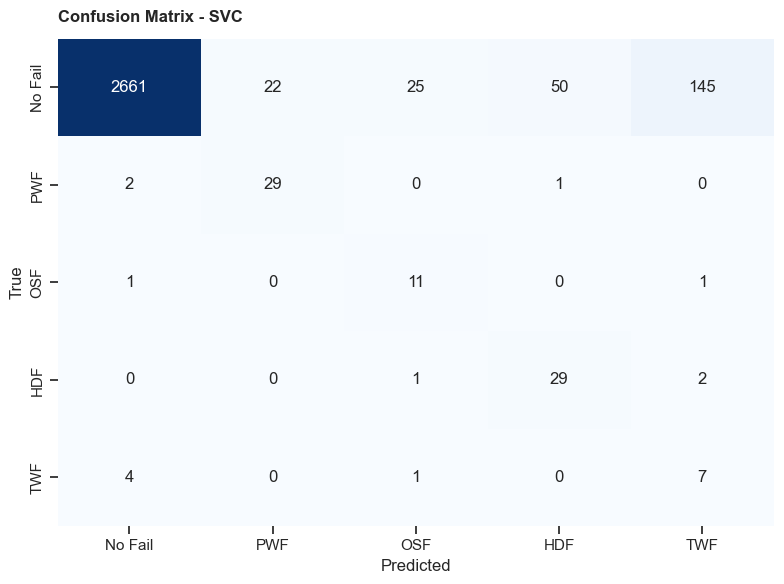


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.88      0.93      2903
           1       0.45      1.00      0.62        32
           2       0.19      0.92      0.32        13
           3       0.29      0.97      0.45        32
           4       0.03      0.50      0.06        12

    accuracy                           0.88      2992
   macro avg       0.39      0.85      0.48      2992
weighted avg       0.98      0.88      0.92      2992




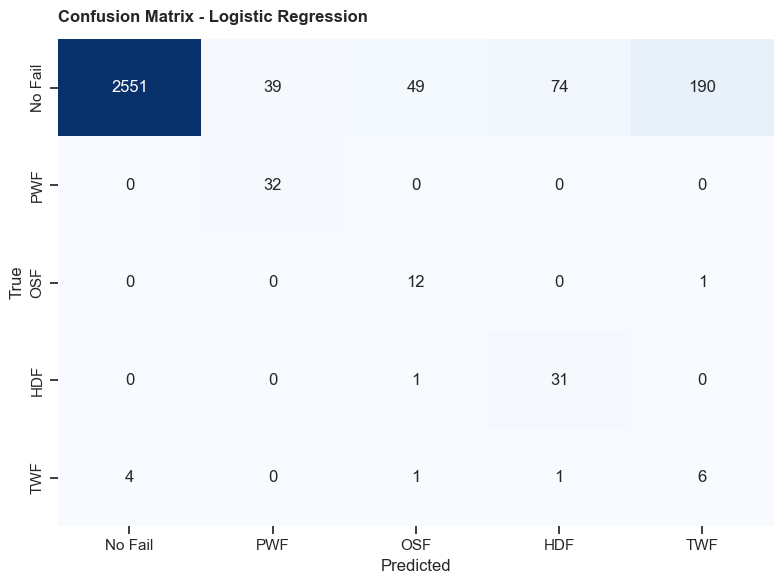


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2903
           1       0.74      0.81      0.78        32
           2       0.44      0.85      0.58        13
           3       0.74      0.81      0.78        32
           4       0.10      0.42      0.16        12

    accuracy                           0.97      2992
   macro avg       0.60      0.77      0.65      2992
weighted avg       0.98      0.97      0.97      2992




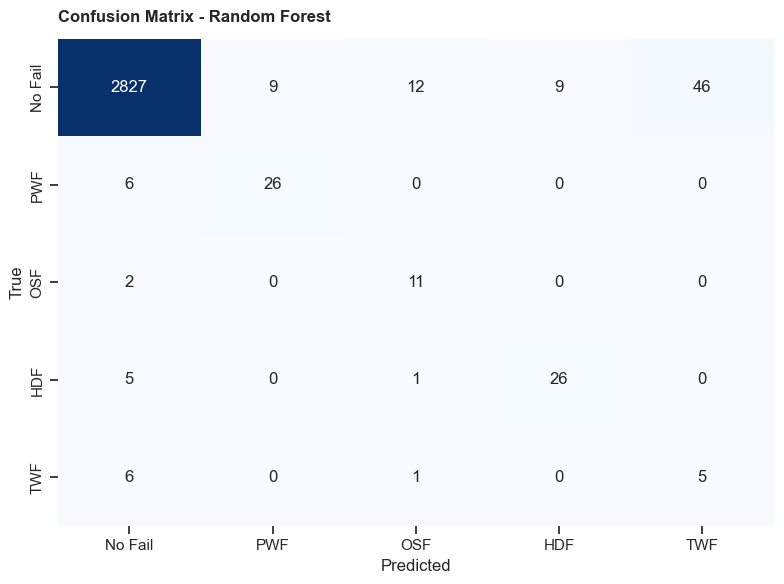


--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2903
           1       0.76      0.88      0.81        32
           2       0.65      0.85      0.73        13
           3       0.84      1.00      0.91        32
           4       0.08      0.25      0.12        12

    accuracy                           0.98      2992
   macro avg       0.66      0.79      0.71      2992
weighted avg       0.99      0.98      0.98      2992




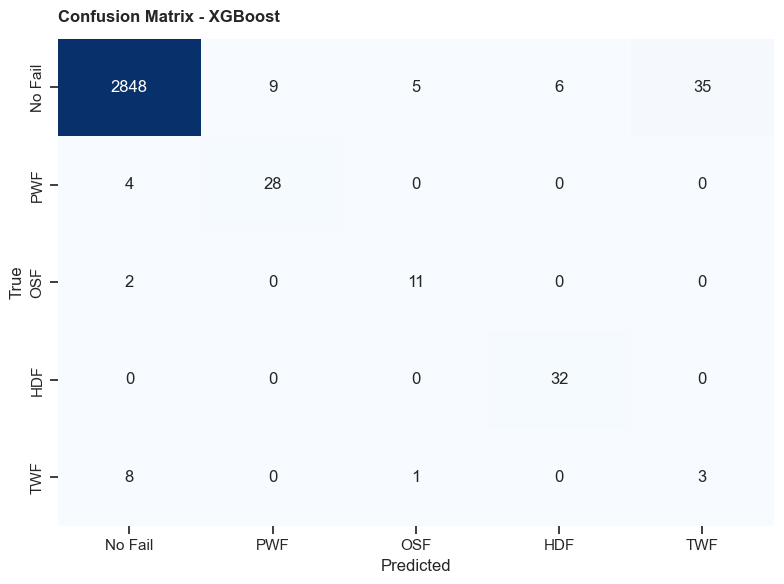


--- LightGBM ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2903
           1       0.74      0.78      0.76        32
           2       0.63      0.92      0.75        13
           3       0.86      0.97      0.91        32
           4       0.10      0.33      0.15        12

    accuracy                           0.98      2992
   macro avg       0.66      0.80      0.71      2992
weighted avg       0.99      0.98      0.98      2992




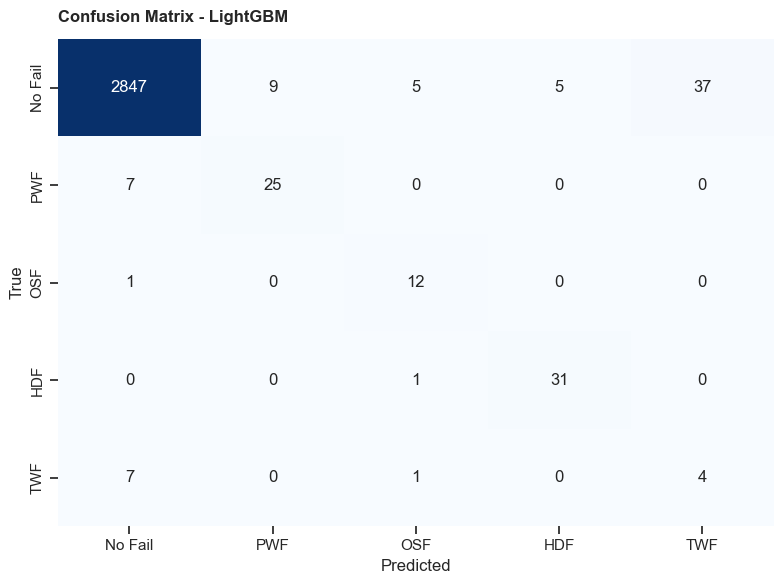


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2903
           1       0.67      0.94      0.78        32
           2       0.39      0.92      0.55        13
           3       0.76      0.97      0.85        32
           4       0.07      0.58      0.13        12

    accuracy                           0.95      2992
   macro avg       0.58      0.87      0.66      2992
weighted avg       0.99      0.95      0.97      2992




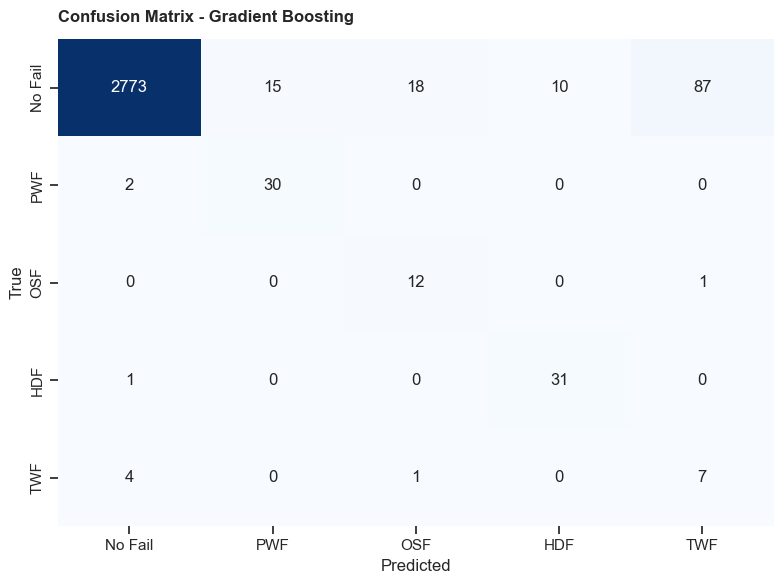

In [98]:
# Avaliando o desempenho dos modelos finais no conjunto de teste com hiperparâmetros
for clf_name, model in trained_models.items():
    print('---', clf_name, '---')
    y_pred_m = model.predict(X_test_m)
    print(classification_report(y_test_m, y_pred_m))
    print()

    # Calculando e exibindo a matriz de confusão como um gráfico
    cm = confusion_matrix(y_test_m, y_pred_m)
    f, ax = plt.subplots(figsize=(8, 6))
    ax= sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {clf_name}', fontsize=12, loc='left', pad=12)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.xaxis.set_ticklabels(['No Fail', 'PWF', 'OSF', 'HDF', 'TWF'])
    ax.yaxis.set_ticklabels(['No Fail', 'PWF', 'OSF', 'HDF', 'TWF'])
    plt.tight_layout()
    plt.show()
    print()